In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2, json, torch, os, re

import util, constants, draw, cam, model, loader, img_proc

np.random.seed(0)
torch.manual_seed(0)

VID_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/harden/'
DATA_ROOT = '/home/akarshkumar0101/Insync/akarshkumar0101@gmail.com/Google Drive/nba-3d-data/'

img_shape_yx = plt.imread(VID_ROOT+'/all_views/frame_00001.png').shape[:2];img_shape_xy = img_shape_yx[::-1]

uf_mat_int_default = cam.get_mat_intrinsic()
uf_mat_int = cam.get_intrinsic_mat_for_img_shape(img_shape_xy)

with open(VID_ROOT+'/md.json') as f:
    data = json.load(f)
    num_views, num_frames = data['num_views'], data['num_frames']
    
print(f'{num_views} views, {num_frames} frames')
print(f'img_shape_xy: {img_shape_xy}')

3 views, 90 frames
img_shape_xy: (1280, 720)


In [6]:
rgb = np.array([(120,76,53),(139,73,56),(122,73,46),(126,84,53),(150,86,71),(128,81,62),(113,68,51),(151,100,81),(103,66,50)])

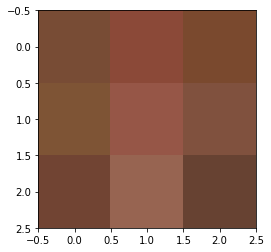

In [11]:
plt.imshow(rgb.reshape(3, 3,3))

In [776]:
np.arange(0,90, 10)

array([ 0, 10, 20, 30, 40, 50, 60, 70, 80])

In [782]:
ball_cols = []

# view 0
locs=np.array([[721, 192],
[542, 288],
[471, 392],
[488, 138],
[499, 124],
[461, 364],
[439, 349],
[735, 392],
[903, 488],
[504, 92]])
frame_idxs = np.array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 34])


for i in range(len(frame_idxs)):
    img = img_proc.to_uint8(loader.load_data_imgs(VID_ROOT, [0], [frame_idxs[i]])[0,0])
    ball_img = img[y-BALL_R: y+BALL_R, x-BALL_R: x+BALL_R]
    x, y = locs[i]
    d = np.sqrt((xc-x)**2+(yc-y)**2)
    ball_cols.append(img[d<8])
    
# view 2
locs = np.array([[779, 265], #0
[286, 259], #
[206, 295],
[178, 79],
[154, 69],
[155, 229],
[188, 296],
[75, 378],
[162, 36]])
frame_idxs = np.array([0, 10, 20, 30, 40, 47, 60, 65, 35])


for i in range(len(frame_idxs)):
    img = img_proc.to_uint8(loader.load_data_imgs(VID_ROOT, [2], [frame_idxs[i]])[0,0])
    ball_img = img[y-BALL_R: y+BALL_R, x-BALL_R: x+BALL_R]
    x, y = locs[i]
    d = np.sqrt((xc-x)**2+(yc-y)**2)
    ball_cols.append(img[d<8])
    
ball_cols = np.concatenate(ball_cols, axis=0)

In [785]:
import sklearn.mixture

In [787]:
model_color = sklearn.mixture.GaussianMixture(19).fit(ball_cols)

In [758]:
view_idx = [2, 2, 2, 0, 0, 0, 0, 2]
frame_idx = [10, 65, 0, 0, 10, 34, 80, 35]
# x, y
loc = [[286, 260], [75, 379], [779, 265], [721, 192], [542, 288], [504, 92], [902, 489], [162, 36]]
r = [10, 7, 9, 9, 9, 9, 9, 9]

In [322]:
view_idx = [2, 2, 0, 0, 0, ]#0, 2]
frame_idx = [10, 0, 0, 10, 34, ]#80, 35]
# x, y
loc = [[286, 260], [779, 265], [721, 192], [542, 288], [504, 92], ]#[902, 489], [162, 36]]
r = [10, 9, 9, 9, 9, 9, 9]

In [759]:
xc, yc = np.arange(img_shape_xy[0]), np.arange(img_shape_xy[1])
xc, yc = np.meshgrid(xc, yc, indexing='xy')

In [760]:
ball_cols_ = []

for i in range(len(frame_idx)):
    img = img_proc.to_uint8(loader.load_data_imgs(VID_ROOT, [view_idx[i]], [frame_idx[i]])[0,0])
#     plt.figure(figsize=(10,10))
#     plt.imshow(img)
#     plt.scatter(loc[i][0], loc[i][1], s=0.3, c='r')
#     plt.show()
    
    d = np.sqrt((xc-loc[i][0])**2+(yc-loc[i][1])**2)

#     ballmask = d<r[i]
    ballmask = d<4
    
    ballimg = img[ballmask]
    ball_cols_.append(ballimg)

ball_cols = np.concatenate(ball_cols_, axis=0)

In [761]:
ball_cols.shape

(360, 3)

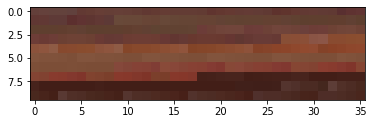

In [762]:
# plt.imshow(ball_cols.reshape(54, 36, 3))
plt.imshow(ball_cols.reshape(10, -1, 3))

In [1006]:
def detect_ball(img):
    img = cv2.edgePreservingFilter(img)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.5,
                              minDist=10,param1=40,param2=20,minRadius=8,maxRadius=12)
    x, y, r = circles[0, :, 0], circles[0, :, 1], circles[0, :, 2]

    
    scores = []
    stds = []
    for xi, yi, ri in zip(x,y,r):
        d = np.sqrt((xc-xi)**2+(yc-yi)**2)
        detection_cols = img[d<8]

        score, std = score_detection(detection_cols, ball_cols)
        scores.append(score)
        stds.append(std)

    scores = np.array(scores)
    stds = np.array(stds)
    fit = scores+2*stds
    inds = np.argsort(fit)[:10]
    
    return x[inds], y[inds], r[inds]


kp_ball = []
for view_idx in range(num_views):
    kp_ball_view = []
    for frame_idx in tqdm(range(num_frames)):
        kp_ball_frame = []
        img = img_proc.to_uint8(loader.load_data_imgs(VID_ROOT, [view_idx], [frame_idx])[0,0])
        x, y, r = detect_ball(img)
        for xi, yi, ri in zip(x, y, r):
            kp_ball_frame.append([xi, yi, ri])
        kp_ball_view.append(kp_ball_frame) 
    kp_ball.append(kp_ball_view)


In [970]:
kp_ball = []
for view_idx in range(num_views):
    kp_ball_view = []
    for frame_idx in range(num_frames):
        kp_ball_frame = []
        for i in range(len(xs[view_idx, frame_idx])):
            kpi = [xs[view_idx, frame_idx][i], ys[view_idx, frame_idx][i], rs[view_idx, frame_idx][i]]
            kp_ball_frame.append(kpi)
        kp_ball_view.append(kp_ball_frame)
    kp_ball.append(kp_ball_view)

IndexError: index 0 is out of bounds for axis 1 with size 0

In [1007]:
np.save(VID_ROOT+'/kp_ball_reg', np.array(kp_ball))

(1, 52, 3)


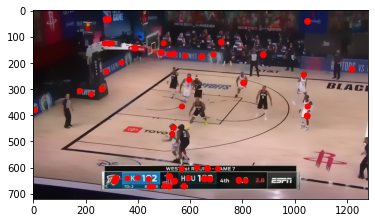

In [925]:
view_idx = 0
frame_idx = 40
img = img_proc.to_uint8(loader.load_data_imgs(VID_ROOT, [view_idx], [frame_idx])[0,0])
img = cv2.edgePreservingFilter(img)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)


# circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT, dp=1.5,
#                               minDist=20,param1=40,param2=28,minRadius=5,maxRadius=13)

circles = cv2.HoughCircles(gray, cv2.HOUGH_GRADIENT, dp=1.5,
                              minDist=10,param1=40,param2=20,minRadius=8,maxRadius=12)
print(circles.shape)
x, y, r = circles[0, :, 0], circles[0, :, 1], circles[0, :, 2]
plt.imshow(img)
for xi, yi, ri in zip(x,y, r):
    circ = plt.Circle((xi, yi), ri, color='r')
    plt.gca().add_artist(circ)
plt.show()

In [926]:
def score_detection(detection_cols, ball_cols):
    arr = detection_cols[:, None, :]-ball_cols[None, :, :]
    dist = np.linalg.norm(arr, axis=-1)
    mindist = dist.min(axis=1)
    s = int(0.4*len(mindist))
    mindist_robust = np.sort(mindist)[:s]
    return mindist_robust.mean(), mindist_robust.std()


def score_detection_lighting_inv(detection_cols, ball_cols):
    ball_cols = cv2.cvtColor(ball_cols.reshape(1,-1, 3), cv2.COLOR_RGB2HSV)[0]
    detection_cols = cv2.cvtColor(detection_cols.reshape(1,-1, 3), cv2.COLOR_RGB2HSV)[0]
    ball_cols = ball_cols[:, :2]
    detection_cols = detection_cols[:, :2]
    
    arr = detection_cols[:, None, :]-ball_cols[None, :, :]
    dist = np.linalg.norm(arr, axis=-1)
    mindist = dist.min(axis=1)
    s = int(0.4*len(mindist))
    mindist_robust = np.sort(mindist)[:s]
#     print(mindist_robust.std())
    return mindist_robust.mean(), mindist_robust.std()

def score_detection_gmm(detection_cols, ball_cols):
    dists = -model_color.score_samples(detection_cols)
    s = int(0.4*len(dists))
    dists_robsut = np.sort(dists)[:s]
    return dists_robsut.mean(), dists_robsut.std()


In [927]:
scores = []
stds = []
for xi, yi, ri in zip(x,y,r):
    d = np.sqrt((xc-xi)**2+(yc-yi)**2)
#     detection_cols = img[d<ri]
    detection_cols = img[d<8]
    
    score, std = score_detection_gmm(detection_cols, ball_cols)
    scores.append(score)
    stds.append(std)
    
scores = np.array(scores)
stds = np.array(stds)

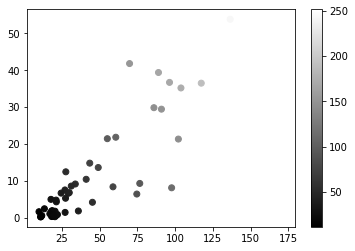

In [928]:
fit = scores+2*stds
plt.scatter(scores, stds, c=fit);plt.colorbar()

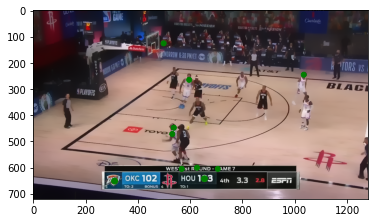

In [929]:
plt.imshow(img)
for deti in np.argsort(fit)[:10]:
    xi, yi, ri = x[deti], y[deti], r[deti]

    circ = plt.Circle((xi, yi), ri, color='g')
    plt.gca().add_artist(circ)
plt.show()

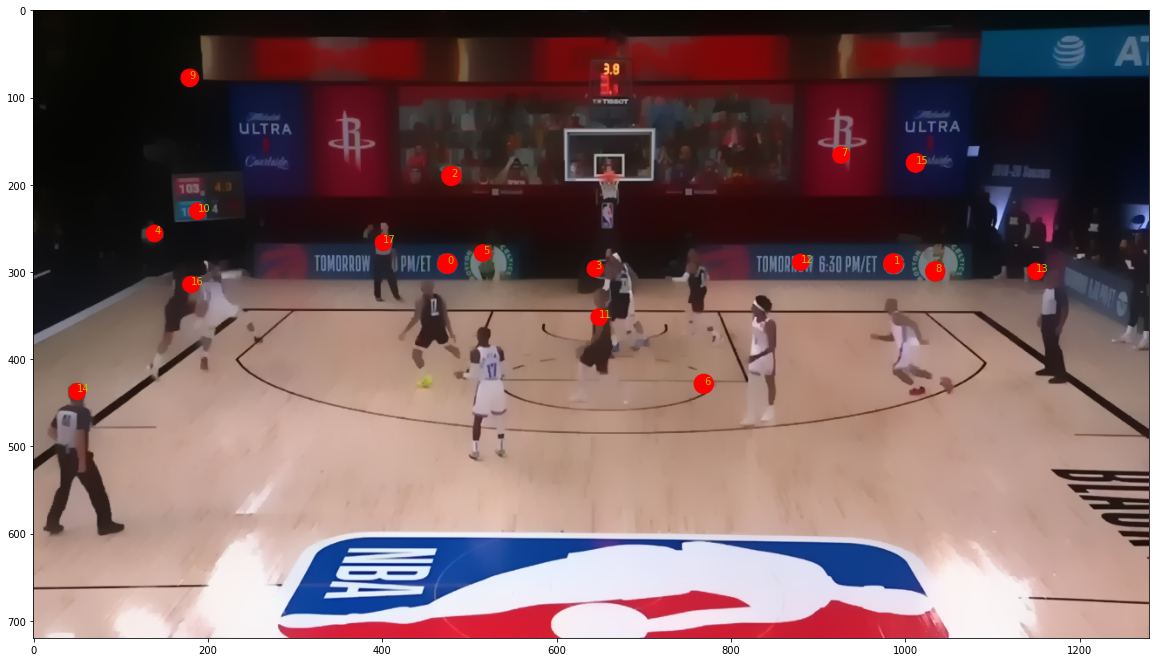

In [889]:
plt.figure(figsize=(20,20))
plt.imshow(img)
i=0
for xi, yi, ri in zip(x,y, r):
    
    circ = plt.Circle((xi, yi), ri, color='r')
    plt.gca().add_artist(circ)
    plt.text(xi, yi, f'{i}', c='y')
    i+=1
plt.show()

In [775]:
print(scores[12])
print(stds[12])

1.3067781457055727
0.37726764757437775


# TEMPLATE MATCHING DOES NOT WORK

In [711]:
BALL_R = 10
templates = []

# view 0
locs=np.array([[721, 192],
[542, 288],
[471, 392],
[488, 138],
[499, 124],
[461, 364],
[439, 349],
[735, 392],
[903, 488],])
frame_idxs = np.arange(0,90, 10)


for i, frame_idx in enumerate(frame_idxs):
    img = img_proc.to_uint8(loader.load_data_imgs(VID_ROOT, [0], [frame_idx])[0,0])
    x, y = locs[i]
    template = img[y-BALL_R: y+BALL_R, x-BALL_R: x+BALL_R]
    templates.append(template)



# view 2
locs = np.array([[779, 265], #0
[286, 259], #
[206, 295],
[178, 79],
[154, 69],
[155, 229], #47
[188, 296], # 60
[75, 378],]) #65
frame_idxs = np.array([0, 10, 20, 30, 40, 47, 60, 65])

for i, frame_idx in enumerate(frame_idxs):
    img = img_proc.to_uint8(loader.load_data_imgs(VID_ROOT, [2], [frame_idx])[0,0])
    x, y = locs[i]
    template = img[y-BALL_R: y+BALL_R, x-BALL_R: x+BALL_R]
    templates.append(template)



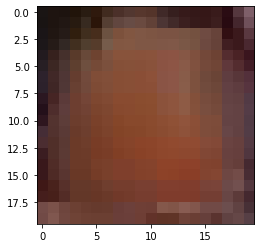

(20, 20, 3)


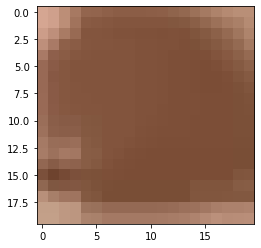

(20, 20, 3)


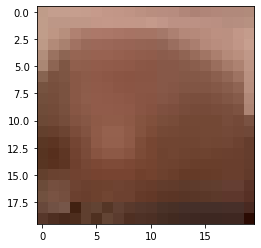

(20, 20, 3)


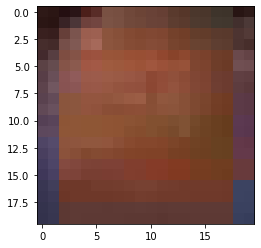

(20, 20, 3)


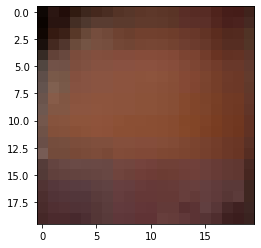

(20, 20, 3)


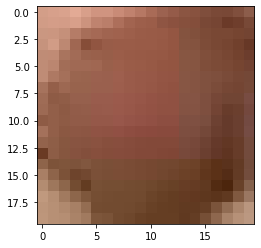

(20, 20, 3)


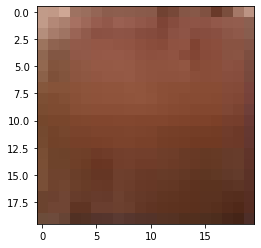

(20, 20, 3)


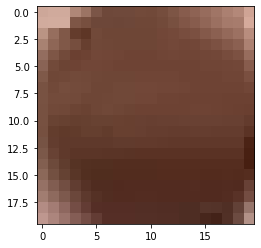

(20, 20, 3)


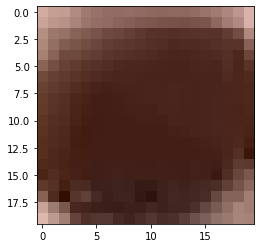

(20, 20, 3)


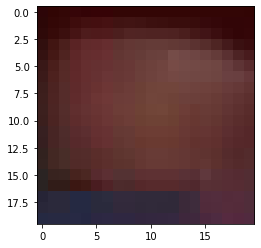

(20, 20, 3)


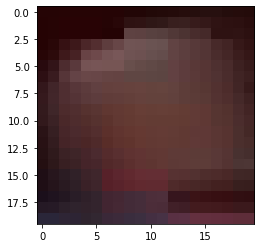

(20, 20, 3)


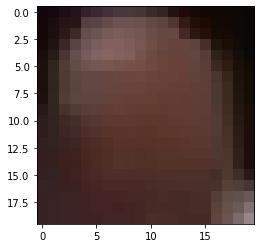

(20, 20, 3)


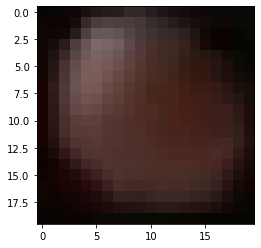

(20, 20, 3)


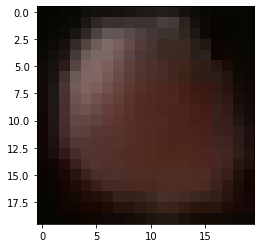

(20, 20, 3)


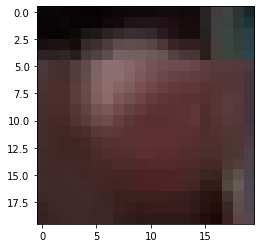

(20, 20, 3)


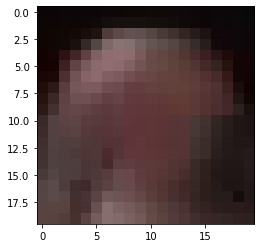

(20, 20, 3)


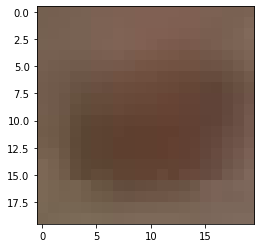

(20, 20, 3)


In [712]:
for template in templates:
    plt.imshow(template);plt.show()
    print(template.shape)

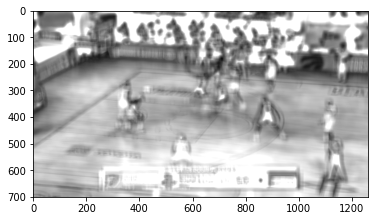

In [754]:
view_idx = 0
frame_idx = 0
img = img_proc.to_uint8(loader.load_data_imgs(VID_ROOT, [view_idx], [frame_idx])[0,0])

res = cv2.matchTemplate(img, templates[0], method=cv2.TM_SQDIFF_NORMED)

plt.imshow(res)


# print(circles.shape)
# x, y, r = circles[0, :, 0], circles[0, :, 1], circles[0, :, 2]
# plt.imshow(img)
# for xi, yi, ri in zip(x,y, r):
#     circ = plt.Circle((xi, yi), ri, color='r')
#     plt.gca().add_artist(circ)
# plt.show()

In [755]:
import skimage.feature

In [756]:
lmi = skimage.feature.peak_local_max(res)

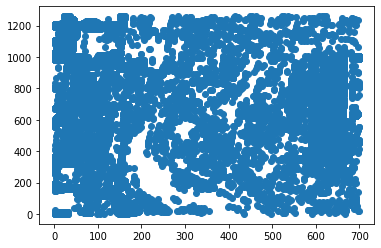

In [757]:
plt.scatter(lmi[:, 0], lmi[:, 1])